## CS 439 - Introduction to Data Science
### Spring 2020

# Final Project: Movie Rating Predictor

<h3>Student Information</h3> Please provide information about yourself. We will NOT grade this submissing w/o all the information<br>
<b>Name</b>: Kaavya Krishna-Kumar, Arjun Sehgal<br>
<b>NetID</b>: kk859, as2591<br>
<b>Recitation</b>: 01<br>
<b>Notes to Grader</b> (optional):<br>

<h3>Summary of Project</h3>

[Back to Contents](#Contents)

For our project we would like to create a model that predicts the success rate of a box office movie such as a fail, hit, or superhit. The premise of this project stemmed from answering the question of whether we could predict the success of the movie only knowing data about a movie prior to  release.<br>

While answering this question, a few question we first asked ourselves were:
* What parameters best predict the success rate of the movie (genre, director, budget, etc.)?
* Which cast or actor best predict the movies?
* Can we look at the genre of the movie to help classify?
* Does the time the movie is released throughout the year influence how the movie does?


## Setup

In [2]:
from sklearn.datasets import load_boston
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso

Importing csv that was cleaned and structued during data cleaning and investigation

In [124]:
movie_genres = pd.read_csv('./data/movie.csv')

In [125]:
def label (row):
    if row['vote_average'] < 3.0:
        return 1
    if row['vote_average'] >= 3.0 and row['vote_average'] <5.0:
        return 2
    if row['vote_average'] >= 5.0 and row['vote_average'] <7.0:
        return 3
    if row['vote_average'] >= 7.0 and row['vote_average'] <=10.0:
        return 4

In [126]:
movie_genres['label']= movie_genres.apply (lambda row: label(row), axis=1)

In [127]:
movie_genres.drop(['movie_id', 'genres', 'director'],axis=1, inplace=True)
movie_genres.head()

,budget,title,release_year,release_month,revenue,vote_average,vote_count,Crime,Family,TV Movie,...,Science Fiction,History,Romance,Western,Foreign,Thriller,Drama,Music,Mystery,label
0,237000000,Avatar,2009.0,12.0,2787965087,7.2,11800,0,0,0,...,1,0,0,0,0,0,0,0,0,4
1,300000000,Pirates of the Caribbean: At World's End,2007.0,5.0,961000000,6.9,4500,0,0,0,...,0,0,0,0,0,0,0,0,0,3
2,245000000,Spectre,2015.0,10.0,880674609,6.3,4466,1,0,0,...,0,0,0,0,0,0,0,0,0,3
3,250000000,The Dark Knight Rises,2012.0,7.0,1084939099,7.6,9106,1,0,0,...,0,0,0,0,0,1,1,0,0,4
4,260000000,John Carter,2012.0,3.0,284139100,6.1,2124,0,0,0,...,1,0,0,0,0,0,0,0,0,3


In [130]:
#Cleaning up the data
movie_genres.isnull().sum()

budget             0
title              0
release_year       1
release_month      1
revenue            0
vote_average       0
vote_count         0
Crime              0
Family             0
TV Movie           0
Fantasy            0
War                0
Animation          0
Action             0
Documentary        0
Comedy             0
Adventure          0
Horror             0
Science Fiction    0
History            0
Romance            0
Western            0
Foreign            0
Thriller           0
Drama              0
Music              0
Mystery            0
label              0
dtype: int64

In [131]:
movie_genres.loc[movie_genres['release_year'].isnull()]

,budget,title,release_year,release_month,revenue,vote_average,vote_count,Crime,Family,TV Movie,...,Science Fiction,History,Romance,Western,Foreign,Thriller,Drama,Music,Mystery,label
4553,0,America Is Still the Place,NaN,NaN,0,0.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [132]:
#Dropping null values
movie_genres.drop(4553, axis=0, inplace=True)

In [133]:
#Cleaning up the data
movie_genres.isnull().sum()

budget             0
title              0
release_year       0
release_month      0
revenue            0
vote_average       0
vote_count         0
Crime              0
Family             0
TV Movie           0
Fantasy            0
War                0
Animation          0
Action             0
Documentary        0
Comedy             0
Adventure          0
Horror             0
Science Fiction    0
History            0
Romance            0
Western            0
Foreign            0
Thriller           0
Drama              0
Music              0
Mystery            0
label              0
dtype: int64

## Feature Selection

In [134]:
genre_corr = movie_genres.corr()
genre_corr['label'].sort_values()

release_year      -0.186258
Horror            -0.137251
Comedy            -0.092235
Action            -0.055659
Thriller          -0.051008
Science Fiction   -0.040237
Family            -0.021186
TV Movie          -0.005275
Fantasy           -0.003679
Foreign            0.013803
Mystery            0.017174
Adventure          0.019065
Western            0.025620
Romance            0.031375
Music              0.038734
Documentary        0.042540
Animation          0.042938
Crime              0.048835
budget             0.085235
War                0.092687
History            0.102106
release_month      0.108238
revenue            0.193900
Drama              0.217102
vote_count         0.317635
vote_average       0.867644
label              1.000000
Name: label, dtype: float64

Feature Selection based off of simple filtering

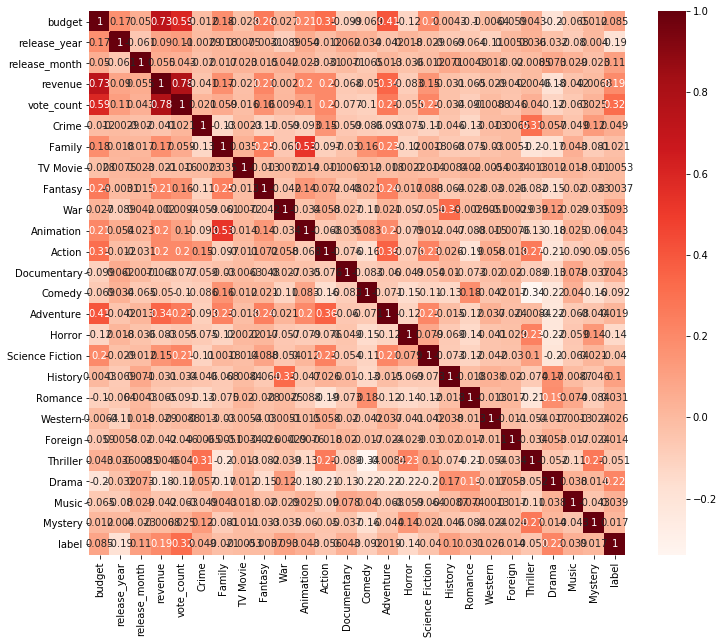

In [164]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = movie_genres.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

The most correlated features can be changed based on the threshold cor_target (We set to 0.08). HAve to be weary of this so not to overfit the model

In [137]:
#Correlation with output variable
cor_target = abs(cor["label"])
#Selecting highly correlated features
relevant_features = cor_target[(cor_target>0.1)]
relevant_features

release_year     0.186258
release_month    0.108238
revenue          0.193900
vote_average     0.867644
vote_count       0.317635
Horror           0.137251
History          0.102106
Drama            0.217102
label            1.000000
Name: label, dtype: float64

For right now we will try to test the model with this simple feature selection. Only using the filtered features right now

In [138]:
test_group1 = movie_genres[['label', 'release_year', 'release_month', 'revenue', 'vote_count','Drama','History','Horror']]

## Splitting Data to Training and Test Data After Feature Selection

In [139]:
#Feature Matrix
X = test_group1.drop("label",1)   
#Target Variable
y = test_group1["label"]     

In [140]:
#splitting the data into training and test sets (80:20)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=4)

In [141]:
#shape of the train and test objects
print(X_train.shape)
print(X_test.shape)

(3841, 7)
(961, 7)


In [142]:
#shape of the y objects
print(y_train.shape)
print(y_test.shape)

(3841,)
(961,)


## Testing K-Nearest-Neighbors (KNN) Algorithm

In [143]:
#import the KNeighborsClassifier class from the sklearn
from sklearn.neighbors import KNeighborsClassifier

#import metrics model to check the accuracy
from sklearn import metrics
#Try running from k=1 through 25 and record testing accuracy
k_range = range(1,25)
scores = {}
scores_list = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train,y_train)
    y_pred=knn.predict(X_test)
    scores[k] = metrics.accuracy_score(y_test,y_pred)
    scores_list.append(metrics.accuracy_score(y_test,y_pred))
    

Text(0, 0.5, 'Testing Accuracy')

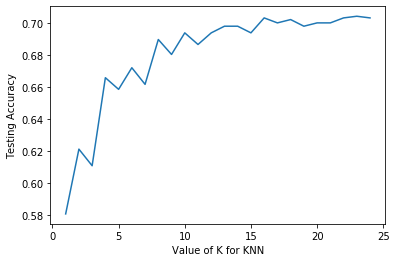

In [144]:
#plot the relationship between K and the testing accuracy
plt.plot(k_range,scores_list)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')

We can see there is a raise and fall in the accuracy and it is quite typical when examining the model complexity with the accuracy. Usually the best K value is selected at the elbow of the curve, so we will select K=8. We will retrain the model with the available with the new K value. 

We chose K=8 so not to overfit the model even though other K values have higher accuracy.

In [145]:
knn = KNeighborsClassifier(n_neighbors=8)
knn.fit(X,y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=8, p=2,
                     weights='uniform')

In [146]:
#renaming the classes
classes = {1:'bad', 2:'okay', 3:'good', 4:'excellent'}
# make up some random test data ..

In [147]:
# making confusion matrix between 
#  test set of Y and predicted value. 
from sklearn.metrics import confusion_matrix 
  
cm = confusion_matrix(y_test, y_pred) 
cm

array([[ 11,   1,   8,   0],
       [  1,   1,  74,   0],
       [  3,   6, 657,  10],
       [  1,   0, 181,   7]], dtype=int64)

The Confusion Matrix is not very accurate. 

## Principle Component Analysis

In [153]:
movie_genres.drop(['title','vote_average'],axis=1, inplace=True)

In [154]:
#Feature Matrix
X = movie_genres.drop("label",1)   
#Target Variable
y = movie_genres["label"]  

In [155]:
#splitting the data into training and test sets (80:20)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=4)

In [156]:
#shape of the train and test objects
print(X_train.shape)
print(X_test.shape)

(3841, 25)
(961, 25)


In [157]:
#shape of the y objects
print(y_train.shape)
print(y_test.shape)

(3841,)
(961,)


In [158]:
# performing preprocessing part 
from sklearn.preprocessing import StandardScaler 
sc = StandardScaler() 
  
X_train = sc.fit_transform(X_train) 
X_test = sc.transform(X_test)

In [159]:
# Applying PCA function on training 
# and testing set of X component 
from sklearn.decomposition import PCA 
  
pca = PCA(n_components = 2) 
  
X_train = pca.fit_transform(X_train) 
X_test = pca.transform(X_test) 
  
explained_variance = pca.explained_variance_ratio_ 

## Re-do KNN with Feature extraction set

In [160]:
#import the KNeighborsClassifier class from the sklearn
from sklearn.neighbors import KNeighborsClassifier

#import metrics model to check the accuracy
from sklearn import metrics
#Try running from k=1 through 25 and record testing accuracy
k_range = range(1,25)
scores = {}
scores_list = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train,y_train)
    y_pred=knn.predict(X_test)
    scores[k] = metrics.accuracy_score(y_test,y_pred)
    scores_list.append(metrics.accuracy_score(y_test,y_pred))

Text(0, 0.5, 'Testing Accuracy')

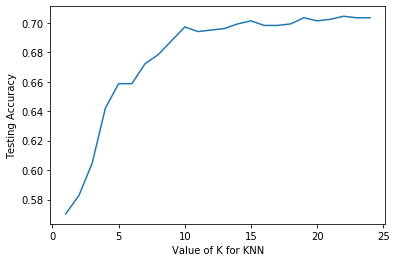

In [161]:
#plot the relationship between K and the testing accuracy
plt.plot(k_range,scores_list)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')

K values have slightly better testing accuracy after using PCA. Selecting K=11 (the elbow of teh graph) and retrain KNN model

In [162]:
knn = KNeighborsClassifier(n_neighbors=11)
knn.fit(X,y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=11, p=2,
                     weights='uniform')

In [163]:
# making confusion matrix between 
#  test set of Y and predicted value. 
from sklearn.metrics import confusion_matrix 
  
cm = confusion_matrix(y_test, y_pred) 
cm

array([[  3,   1,  16,   0],
       [  1,   4,  71,   0],
       [  3,   4, 661,   8],
       [  0,   0, 181,   8]], dtype=int64)

Training the KNN model after PCA significantly improves the accuracy. From the confusion matrix, you can see the biggest difference in the prediction of rating 2 and rating 4. Before, the KNN model rated more level 2 movies as level 3 and more level 4 movies as level 3. This model does better in correctly labeling